# H&E usage
The purpose of this notebook is to showcase how to perform basic analyses of H&E data and eventually combine it other modalities (transcriptomics or multiplex imaging).

You will need the `wsi` extra of sopa for this tutorial, i.e. `pip install sopa[wsi]`

In [1]:
import sopa.io

import spatialdata_io
import spatialdata_plot

from pathlib import Path

For this tutorial, we will use [this Xenium pancreatic cancer dataset](https://www.10xgenomics.com/datasets/pancreatic-cancer-with-xenium-human-multi-tissue-and-cancer-panel-1-standard). In particular, it has H&E attached to the spatial transcriptomics. You can also use the H&E alone by using the `sopa.io.wsi` reader.

To keep it simple, we will assume the Sopa pipeline has already been run, and for the sake of this tutorial we will directly use the Xenium default segmentation. If you use your own data after running Sopa, simply read your data with the `spatialdata.read_zarr` function.

In [ ]:
# here, we will directly open the processed Xenium directory
directory = Path("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs")
sdata = spatialdata_io.xenium(directory, morphology_focus=False)

If you have already aligned the H&E image as in [this tutorial](https://gustaveroussy.github.io/sopa/tutorials/align/), you can now add it to your `SpatialData` object:

In [ ]:
# reading the H&E image
image = sopa.io.wsi(directory / "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_image.ome.tif", as_image=True)

# this is the path to the alignment file
transformation_matrix_path = directory / "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_imagealignment.csv"

sopa.io.align(sdata, image, transformation_matrix_path)

# this is the name of the HE image that has been added
he_image_key = 'Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_image.ome'

## Tissue segmentation

Optionally, we can run tissue segmentation. This will create new polygons saved inside `sdata['region_of_interest']`:

In [4]:
from sopa.segmentation.tissue import hsv_otsu

hsv_otsu(sdata, image_key=he_image_key)

[INFO] (sopa.segmentation.tissue) Tissue segmentation saved in sdata['region_of_interest']


True

The tissue segmentation can be shown as below: 

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


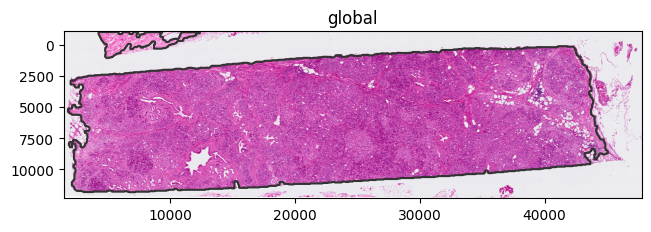

In [5]:
sdata\
    .pl.render_shapes("region_of_interest", outline=True, fill_alpha=0, outline_color="#333")\
    .pl.render_images(he_image_key, scale="scale3")\
    .pl.show("global")

## Patches embeddings and clusters

It is common to embed H&E patches using a computer vision model. Here, we use a ResNet model to embedding patches. On the following example, we compute embeddings for patches of width `250` pixels at the level 1 (i.e., the first sub-resolution image).

You can adjust the level to get different resolutions. For instance, `level=0, patch_width=100` would produce a resolution of about one cell per patch.

In [6]:
from sopa.patches.infer import infer_wsi_patches
from sopa.patches.cluster import cluster_embeddings

In [7]:
embedding = infer_wsi_patches(
    sdata, "Resnet50Features", patch_width=250, level=1, image_key=he_image_key
)

[INFO] (sopa.embedding.patches) Computing 4201 embeddings at level 1
100%|██████████| 132/132 [09:45<00:00,  4.43s/it]
[INFO] (sopa.embedding.patches) WSI embeddings saved as an image in sdata['sopa_Resnet50Features']
[INFO] (sopa.segmentation.patching) 4201 patches were saved in sdata['sopa_embedding_patches']


Then, clustering can be run on the patches embeddings. This will generate a `GeoDataFrame` under `sdata["sopa_patches_inference"]`, as below. Note the `"cluster"` column that has been added.

In [8]:
cluster_embeddings(sdata, 'sopa_Resnet50Features')

sdata["sopa_patches_inference"]

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,geometry,bboxes,ilocs,cluster
0,"POLYGON ((6500.000 1000.000, 6500.000 640.098,...","[6000, 500, 6500, 1000]","[12, 1]",7
1,"POLYGON ((6500.000 1000.000, 6789.944 1000.000...","[6500, 500, 7000, 1000]","[13, 1]",7
2,"POLYGON ((10500.000 1000.000, 10500.000 581.28...","[10000, 500, 10500, 1000]","[20, 1]",7
3,"POLYGON ((10500.000 1000.000, 10993.471 1000.0...","[10500, 500, 11000, 1000]","[21, 1]",12
4,"POLYGON ((14000.000 1000.000, 14000.000 832.12...","[13500, 500, 14000, 1000]","[27, 1]",8
...,...,...,...,...
4196,"POLYGON ((6000.000 67000.000, 5527.091 67000.0...","[5500, 67000, 6000, 67500]","[11, 134]",12
4197,"POLYGON ((6500.000 67000.000, 6000.000 67000.0...","[6000, 67000, 6500, 67500]","[12, 134]",12
4198,"POLYGON ((7000.000 67000.000, 6500.000 67000.0...","[6500, 67000, 7000, 67500]","[13, 134]",12
4199,"POLYGON ((7000.000 67000.000, 7000.000 67256.4...","[7000, 67000, 7500, 67500]","[14, 134]",12


The patches clusters can be shown with `spatialdata_plot`:

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


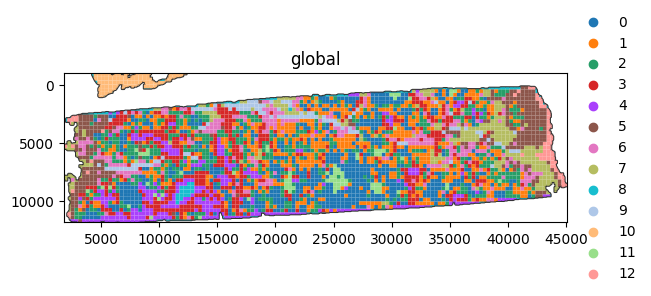

In [9]:
sdata\
    .pl.render_shapes("region_of_interest", outline=True, fill_alpha=0, outline_color="#333")\
    .pl.render_shapes("sopa_patches_inference", color="cluster")\
    .pl.show("global")

## Spatial join

You may be interested in joining the H&E patches and the cells. This way, you could know inside witch patch-cluster belongs each cell. This can be done with `sopa.spatial.sjoin`.

In [10]:
import sopa.spatial

In [11]:
res_gdf = sopa.spatial.sjoin(sdata, "cell_boundaries", "sopa_patches_inference", target_coordinate_system="global")

The resulting `GeoDataFrame` may have more columns than cells, because one cell may be inside multiple patches. We will keep only the first patch, and then save the resulting `"cluster"` column into the `sdata.tables["table"]`.

In [12]:
sdata.tables["table"].obs["cluster"] = res_gdf[~res_gdf.index.duplicated()]["cluster"].values

Now, we can plot the cells and their associated H&E cluster:

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.10/lib/python3.10/site-packages/spatialdata/_utils.py:212: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  obs[column] = c


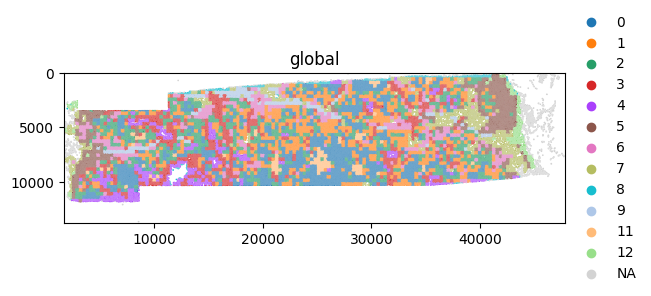

In [13]:
sdata.pl.render_shapes("cell_boundaries", color="cluster").pl.show("global")